In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od
import torch
import torch.nn as nn
import torch.optim as optim
import os
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from tqdm.notebook import tqdm

In [3]:
dataset_url = 'https://www.kaggle.com/greg115/abstract-art'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: wastex
Your Kaggle Key: ··········


  2%|▏         | 5.00M/296M [00:00<00:07, 39.6MB/s]

100%|██████████| 296M/296M [00:03<00:00, 91.5MB/s]


In [4]:
data_dir = './abstract-art'
print(os.listdir(data_dir))

['abstract_art_512']


In [5]:
print(os.listdir(data_dir+'/abstract_art_512')[:10])

['abstract_vasile-dobrian_3636.jpg', 'abstract_kuno-gonschior_5153.jpg', 'abstract_leon-berkowitz_1440.jpg', 'abstract_norman-bluhm_1733.jpg', 'abstract_jose-guerrero_5454.jpg', 'abstract_luciano-bartolini_1141.jpg', 'abstract_rudolf-bauer_1226.jpg', 'abstract_marcel-barbeau_1041.jpg', 'abstract_mark-lancaster_7247.jpg', 'abstract_gunther-forg_4631.jpg']


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img_size = 128
num_channels = 3
latent_size = 100
batch_size = 128
features_g = 64
features_d = 16
num_epochs = 300
lr = 2e-4
fixed_latent = torch.randn(batch_size, latent_size, 1, 1).to(device)
criterion = nn.BCELoss().to(device)

In [7]:
train_ds = ImageFolder(root=data_dir,
                      transform=tt.Compose([
                        tt.Resize(img_size),
                        tt.ToTensor(),
                        tt.Normalize((0.5), (0.5))
                      ]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, drop_last=True)

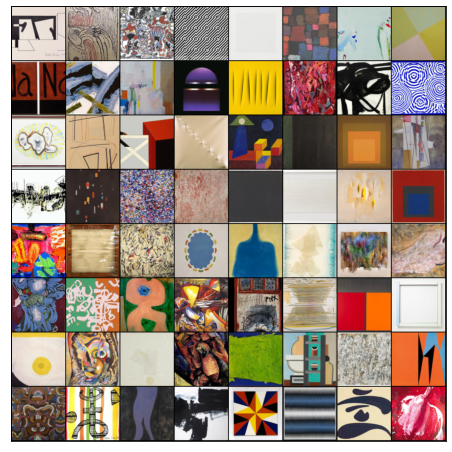

In [8]:
def show_batch(dl):
  for images, _ in dl:
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images[:64], normalize=True).permute(1, 2, 0))
    break

show_batch(train_dl)

In [9]:
class Generator(nn.Module):
  def __init__(self, features_g, latent_size, num_channels):
    super(Generator, self).__init__()
    self.net = nn.Sequential(
        self.deConvBlock(latent_size, features_g*16, 4, 1, 0),
        self.deConvBlock(features_g*16, features_g*8, 4, 2, 1),
        self.deConvBlock(features_g*8, features_g*4, 4, 2, 1),
        self.deConvBlock(features_g*4, features_g*2, 4, 2, 1),
        self.deConvBlock(features_g*2, features_g, 4, 2, 1),
        nn.ConvTranspose2d(features_g, num_channels, 4, 2, 1),
        nn.Tanh()
    )

  def deConvBlock(self, in_channels, out_channels, kernel_size, stride, padding, bias=False):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2, inplace=True),
        #nn.ReLU(inplace=True),
    )

  def forward(self, x):
    return self.net(x)

In [10]:
class Discriminator1(nn.Module):
  def __init__(self, features_d, num_channels):
    super(Discriminator1, self).__init__()
    self.net = nn.Sequential(
        nn.Conv2d(num_channels, features_d, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        self.ConvBlock(features_d, features_d*2, 4, 2, 1, bias=False),
        self.ConvBlock(features_d*2, features_d*4, 4, 2, 1, bias=False),
        self.ConvBlock(features_d*4, features_d*8, 4, 2, 1, bias=False),
        self.ConvBlock(features_d*8, features_d*16, 4, 2, 1, bias=False),
        nn.Conv2d(features_d*16, 1, 4, 1, 0, False),
        nn.Flatten(),
        nn.Sigmoid()
    )


  def ConvBlock(self, in_channels, out_channels, kernel_size, stride, padding, bias=False):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2, inplace=True),
    )

  def forward(self, x):
    return self.net(x)

In [11]:
class Discriminator(nn.Module):
    def __init__(self, features_d, num_channels):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(num_channels, features_d, 4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(features_d),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(features_d, features_d* 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features_d * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(features_d * 2, features_d * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features_d * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16 
            nn.Conv2d(features_d * 4, features_d * 8, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features_d * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8
            nn.Conv2d(features_d * 8, features_d * 16, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features_d * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(features_d * 16, 1, 4, stride=1, padding=0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
            # state size. 1
        )

    def forward(self, input):
        return self.main(input)

In [12]:
def initialize_weights(model):
  for module in model.modules():
    if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
      nn.init.normal_(module.weight.data, 0.0, 0.02)
    elif isinstance(module, nn.BatchNorm2d):
      nn.init.normal_(module.weight.data, 1.0, 0.02)
      nn.init.constant_(module.bias.data, 0)

In [13]:
netG = Generator(features_g, latent_size, num_channels).to(device)
netD = Discriminator(features_d, num_channels).to(device)
initialize_weights(netG)
initialize_weights(netD)

optimG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))
optimD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))

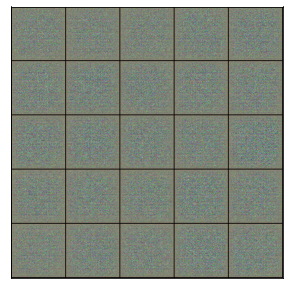

In [14]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent, show=True):
  fake_images = netG(latent)[:25]
  fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
  grid = make_grid(fake_images.cpu().detach(), nrow=5, normalize=True)
  save_image(grid, os.path.join(sample_dir, fake_fname))
  if show:
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(grid.permute(1, 2, 0))

save_samples(0, fixed_latent)

In [15]:
real_targets = (torch.ones(batch_size, 1) - torch.rand(batch_size, 1) * 0.2).to(device)
fake_targets = (torch.zeros(batch_size, 1) + torch.rand(batch_size, 1) * 0.2).to(device)
losses_g, losses_d = [], [] 
for epoch in range(num_epochs):
  for batch_idx, (images, _) in enumerate(tqdm(train_dl)):
    # training discriminator
    netD.zero_grad()
    images = images.to(device)
    real_preds = netD(images)
    disc_real_loss = criterion(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    noise = torch.randn(batch_size, latent_size, 1, 1).to(device)
    fake_images = netG(noise)
    fake_preds = netD(fake_images.detach())
    disc_fake_loss = criterion(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    disc_loss = torch.log(disc_real_loss) + torch.log(disc_fake_loss)
    disc_loss.backward()
    optimD.step()

    # training generator
    netG.zero_grad()
    
    upd_fake_preds = netD(fake_images)
    gen_loss = torch.log(criterion(upd_fake_preds, real_targets))
    upd_fake_score = torch.mean(upd_fake_preds).item()
    """
    fake = netG(noise)
    preds = netD(fake)
    gen_loss = criterion(preds, real_targets)
    upd_fake_score = torch.mean(preds).item()
    """
    y = gen_loss
    gen_loss.backward()
    optimG.step()

    losses_d.append(disc_loss)
    losses_g.append(gen_loss)

  print('Epoch [{}/{}], Loss_D: {:.4f}, Loss_G: {:.4f}, D(x): {:.4f}, D(G(z)): {:.4f}/{:.4f}'.format(
      epoch+1, num_epochs, disc_loss, gen_loss, real_score, fake_score, upd_fake_score
  ))
  with torch.no_grad():
    save_samples(epoch+1, fixed_latent, show=False)



Epoch [1/300], Loss_D: -1.8745, Loss_G: 1.2677, D(x): 0.7162, D(G(z)): 0.1099/0.0227



Epoch [2/300], Loss_D: -2.0761, Loss_G: 0.9834, D(x): 0.7874, D(G(z)): 0.0864/0.0538



Epoch [3/300], Loss_D: -2.0017, Loss_G: 0.5929, D(x): 0.8609, D(G(z)): 0.0568/0.1415



Epoch [4/300], Loss_D: -2.1189, Loss_G: 1.1782, D(x): 0.7970, D(G(z)): 0.1323/0.0289



Epoch [5/300], Loss_D: -2.2437, Loss_G: 1.2798, D(x): 0.9192, D(G(z)): 0.1366/0.0202



Epoch [6/300], Loss_D: -2.1983, Loss_G: 0.8988, D(x): 0.8679, D(G(z)): 0.1219/0.0697



Epoch [7/300], Loss_D: -1.0450, Loss_G: -0.0027, D(x): 0.4866, D(G(z)): 0.3272/0.3504



Epoch [8/300], Loss_D: -2.0993, Loss_G: 0.7547, D(x): 0.8477, D(G(z)): 0.0777/0.1071



Epoch [9/300], Loss_D: -0.8167, Loss_G: 0.2065, D(x): 0.4055, D(G(z)): 0.3134/0.2922



Epoch [10/300], Loss_D: -0.6838, Loss_G: -0.4648, D(x): 0.7001, D(G(z)): 0.6895/0.5614



Epoch [11/300], Loss_D: -1.3733, Loss_G: 0.4458, D(x): 0.7990, D(G(z)): 0.4800/0.1908



Epoch [12/300], Loss_D: -1.5234, Loss_G: 1.1764, D(x): 0.8501, D(G(z)): 0.4553/0.0316



Epoch [13/300], Loss_D: -1.6738, Loss_G: -0.0571, D(x): 0.6046, D(G(z)): 0.1195/0.3767



Epoch [14/300], Loss_D: -1.2593, Loss_G: 0.2758, D(x): 0.5257, D(G(z)): 0.2370/0.2564



Epoch [15/300], Loss_D: -1.3197, Loss_G: 0.7597, D(x): 0.6001, D(G(z)): 0.2482/0.1125



Epoch [16/300], Loss_D: -1.0283, Loss_G: 0.1405, D(x): 0.3613, D(G(z)): 0.1372/0.3211



Epoch [17/300], Loss_D: -0.5281, Loss_G: 0.3163, D(x): 0.5411, D(G(z)): 0.5761/0.2422



Epoch [18/300], Loss_D: -1.1164, Loss_G: 0.7246, D(x): 0.6199, D(G(z)): 0.3985/0.1131



Epoch [19/300], Loss_D: -0.5025, Loss_G: 0.2683, D(x): 0.3510, D(G(z)): 0.3770/0.2587



Epoch [20/300], Loss_D: -1.7344, Loss_G: 0.4408, D(x): 0.7189, D(G(z)): 0.2294/0.1974



Epoch [21/300], Loss_D: -1.4442, Loss_G: 0.7695, D(x): 0.7168, D(G(z)): 0.3702/0.1037



Epoch [22/300], Loss_D: -0.7672, Loss_G: 0.6520, D(x): 0.3151, D(G(z)): 0.2007/0.1361



Epoch [23/300], Loss_D: -1.6004, Loss_G: 0.0265, D(x): 0.6014, D(G(z)): 0.1746/0.3515



Epoch [24/300], Loss_D: -0.8767, Loss_G: 0.3665, D(x): 0.6878, D(G(z)): 0.5723/0.2388



Epoch [25/300], Loss_D: -0.9036, Loss_G: 0.2807, D(x): 0.3138, D(G(z)): 0.1510/0.2551



Epoch [26/300], Loss_D: -1.1789, Loss_G: 0.6371, D(x): 0.7951, D(G(z)): 0.5579/0.1340



Epoch [27/300], Loss_D: -1.4702, Loss_G: 0.3616, D(x): 0.5608, D(G(z)): 0.1916/0.2331



Epoch [28/300], Loss_D: -1.7547, Loss_G: 0.8139, D(x): 0.8025, D(G(z)): 0.2940/0.0890



Epoch [29/300], Loss_D: -1.5265, Loss_G: 0.8857, D(x): 0.8578, D(G(z)): 0.4570/0.0735



Epoch [30/300], Loss_D: -1.2108, Loss_G: 0.3381, D(x): 0.6586, D(G(z)): 0.4088/0.2311



Epoch [31/300], Loss_D: -1.5063, Loss_G: 0.8141, D(x): 0.7440, D(G(z)): 0.3333/0.0997



Epoch [32/300], Loss_D: -1.4442, Loss_G: 0.2104, D(x): 0.7081, D(G(z)): 0.3609/0.2818



Epoch [33/300], Loss_D: -0.9206, Loss_G: 0.3620, D(x): 0.6258, D(G(z)): 0.4843/0.2339



Epoch [34/300], Loss_D: -1.1983, Loss_G: 0.4193, D(x): 0.5164, D(G(z)): 0.2718/0.2021



Epoch [35/300], Loss_D: -1.3270, Loss_G: 0.9630, D(x): 0.8306, D(G(z)): 0.5203/0.0627



Epoch [36/300], Loss_D: -0.9990, Loss_G: 0.7789, D(x): 0.4291, D(G(z)): 0.2110/0.1150



Epoch [37/300], Loss_D: -1.5109, Loss_G: 0.7039, D(x): 0.7199, D(G(z)): 0.3575/0.1163



Epoch [38/300], Loss_D: -0.7241, Loss_G: 0.3426, D(x): 0.7948, D(G(z)): 0.7332/0.2318



Epoch [39/300], Loss_D: -1.3107, Loss_G: 0.6131, D(x): 0.6431, D(G(z)): 0.2856/0.1529



Epoch [40/300], Loss_D: -1.0344, Loss_G: 0.7065, D(x): 0.8894, D(G(z)): 0.6519/0.1214



Epoch [41/300], Loss_D: -1.1361, Loss_G: 0.3679, D(x): 0.4908, D(G(z)): 0.2716/0.2203



Epoch [42/300], Loss_D: -0.8852, Loss_G: 0.6755, D(x): 0.5532, D(G(z)): 0.4398/0.1367



Epoch [43/300], Loss_D: -1.5403, Loss_G: 0.4360, D(x): 0.5878, D(G(z)): 0.1626/0.1993



Epoch [44/300], Loss_D: -1.2226, Loss_G: 0.4444, D(x): 0.6610, D(G(z)): 0.4171/0.1932



Epoch [45/300], Loss_D: -1.2097, Loss_G: 0.6155, D(x): 0.7913, D(G(z)): 0.5328/0.1422



Epoch [46/300], Loss_D: -0.5883, Loss_G: -0.1911, D(x): 0.7703, D(G(z)): 0.7673/0.4492



Epoch [47/300], Loss_D: -0.7647, Loss_G: 0.6884, D(x): 0.5516, D(G(z)): 0.4862/0.1245



Epoch [48/300], Loss_D: -1.2017, Loss_G: 0.2092, D(x): 0.4347, D(G(z)): 0.1388/0.2909



Epoch [49/300], Loss_D: -0.7705, Loss_G: 0.0035, D(x): 0.8213, D(G(z)): 0.7269/0.3746



Epoch [50/300], Loss_D: -1.3331, Loss_G: 0.5012, D(x): 0.8636, D(G(z)): 0.5370/0.1778



Epoch [51/300], Loss_D: -0.9642, Loss_G: 0.4143, D(x): 0.4960, D(G(z)): 0.3486/0.2104



Epoch [52/300], Loss_D: -1.4119, Loss_G: 0.6287, D(x): 0.5836, D(G(z)): 0.2295/0.1566



Epoch [53/300], Loss_D: -0.5751, Loss_G: -0.0525, D(x): 0.4857, D(G(z)): 0.5082/0.3887



Epoch [54/300], Loss_D: -1.6098, Loss_G: 0.9168, D(x): 0.8000, D(G(z)): 0.3649/0.0709



Epoch [55/300], Loss_D: -1.1201, Loss_G: 0.4808, D(x): 0.5368, D(G(z)): 0.3187/0.1902



Epoch [56/300], Loss_D: -1.2923, Loss_G: 0.8491, D(x): 0.8187, D(G(z)): 0.5191/0.0874



Epoch [57/300], Loss_D: -1.3590, Loss_G: 0.9838, D(x): 0.7516, D(G(z)): 0.4256/0.0604



Epoch [58/300], Loss_D: -1.4542, Loss_G: 0.9245, D(x): 0.7853, D(G(z)): 0.4078/0.0703



Epoch [59/300], Loss_D: -0.4661, Loss_G: 0.4737, D(x): 0.5947, D(G(z)): 0.6496/0.1973



Epoch [60/300], Loss_D: -1.7993, Loss_G: 1.0710, D(x): 0.7888, D(G(z)): 0.2440/0.0535



Epoch [61/300], Loss_D: -1.5132, Loss_G: 0.8660, D(x): 0.7418, D(G(z)): 0.3518/0.0832



Epoch [62/300], Loss_D: -1.6616, Loss_G: 0.6825, D(x): 0.7351, D(G(z)): 0.2781/0.1285



Epoch [63/300], Loss_D: -1.6906, Loss_G: 0.6407, D(x): 0.7211, D(G(z)): 0.2357/0.1430



Epoch [64/300], Loss_D: -1.2556, Loss_G: 0.6275, D(x): 0.7099, D(G(z)): 0.4065/0.1521



Epoch [65/300], Loss_D: -1.3116, Loss_G: 0.5267, D(x): 0.5869, D(G(z)): 0.2794/0.1771



Epoch [66/300], Loss_D: -1.6907, Loss_G: 0.9265, D(x): 0.7752, D(G(z)): 0.2789/0.0754



Epoch [67/300], Loss_D: -1.7958, Loss_G: 0.4679, D(x): 0.6981, D(G(z)): 0.0886/0.1934



Epoch [68/300], Loss_D: -0.8713, Loss_G: 0.4654, D(x): 0.5812, D(G(z)): 0.4594/0.2062



Epoch [69/300], Loss_D: -1.3318, Loss_G: 0.6103, D(x): 0.6428, D(G(z)): 0.3215/0.1479



Epoch [70/300], Loss_D: -1.2935, Loss_G: 0.4205, D(x): 0.7930, D(G(z)): 0.4745/0.2105



Epoch [71/300], Loss_D: -1.7442, Loss_G: 1.1005, D(x): 0.8452, D(G(z)): 0.3316/0.0419



Epoch [72/300], Loss_D: -1.4441, Loss_G: 0.3243, D(x): 0.5546, D(G(z)): 0.0907/0.2542



Epoch [73/300], Loss_D: -1.2806, Loss_G: 0.4139, D(x): 0.5031, D(G(z)): 0.0433/0.2134



Epoch [74/300], Loss_D: -1.3402, Loss_G: 0.1597, D(x): 0.4910, D(G(z)): 0.1165/0.3066



Epoch [75/300], Loss_D: -2.0179, Loss_G: 0.6371, D(x): 0.7882, D(G(z)): 0.1012/0.1386



Epoch [76/300], Loss_D: -1.8246, Loss_G: 0.5419, D(x): 0.7151, D(G(z)): 0.1721/0.1657



Epoch [77/300], Loss_D: -1.5829, Loss_G: 0.4036, D(x): 0.6908, D(G(z)): 0.2840/0.2080



Epoch [78/300], Loss_D: -2.0725, Loss_G: 1.0438, D(x): 0.8597, D(G(z)): 0.1879/0.0489



Epoch [79/300], Loss_D: -1.8445, Loss_G: 0.4620, D(x): 0.6822, D(G(z)): 0.1083/0.1920



Epoch [80/300], Loss_D: -1.8853, Loss_G: 0.5142, D(x): 0.7149, D(G(z)): 0.1306/0.1796



Epoch [81/300], Loss_D: -1.7136, Loss_G: 0.6375, D(x): 0.6868, D(G(z)): 0.1884/0.1378



Epoch [82/300], Loss_D: -1.3352, Loss_G: 0.3514, D(x): 0.4763, D(G(z)): 0.0738/0.2326



Epoch [83/300], Loss_D: -1.6466, Loss_G: 0.8689, D(x): 0.8160, D(G(z)): 0.3505/0.0852



Epoch [84/300], Loss_D: -0.9522, Loss_G: 0.3835, D(x): 0.3523, D(G(z)): 0.0646/0.2254



Epoch [85/300], Loss_D: -1.7596, Loss_G: 0.8941, D(x): 0.8559, D(G(z)): 0.3451/0.0767



Epoch [86/300], Loss_D: -1.8978, Loss_G: 0.5981, D(x): 0.7448, D(G(z)): 0.1567/0.1527



Epoch [87/300], Loss_D: -1.9370, Loss_G: 1.1741, D(x): 0.8478, D(G(z)): 0.2322/0.0364



Epoch [88/300], Loss_D: -2.0612, Loss_G: 0.7279, D(x): 0.8032, D(G(z)): 0.0679/0.1147



Epoch [89/300], Loss_D: -1.3950, Loss_G: 0.5262, D(x): 0.6240, D(G(z)): 0.2793/0.1803



Epoch [90/300], Loss_D: -1.4184, Loss_G: 0.5065, D(x): 0.5847, D(G(z)): 0.2222/0.1809



Epoch [91/300], Loss_D: -1.9060, Loss_G: 0.5279, D(x): 0.7813, D(G(z)): 0.1978/0.1722



Epoch [92/300], Loss_D: -1.5308, Loss_G: 1.0676, D(x): 0.8225, D(G(z)): 0.4113/0.0468



Epoch [93/300], Loss_D: -1.8316, Loss_G: 1.2148, D(x): 0.8899, D(G(z)): 0.3206/0.0277



Epoch [94/300], Loss_D: -1.7866, Loss_G: 0.7784, D(x): 0.7054, D(G(z)): 0.1862/0.1043



Epoch [95/300], Loss_D: -1.6305, Loss_G: 1.0332, D(x): 0.9078, D(G(z)): 0.4104/0.0523



Epoch [96/300], Loss_D: -2.0042, Loss_G: 0.8793, D(x): 0.7820, D(G(z)): 0.1450/0.0785



Epoch [97/300], Loss_D: -1.5507, Loss_G: 0.5649, D(x): 0.8544, D(G(z)): 0.4297/0.1614



Epoch [98/300], Loss_D: -1.8654, Loss_G: 0.4217, D(x): 0.7104, D(G(z)): 0.1046/0.2130



Epoch [99/300], Loss_D: -2.0592, Loss_G: 0.6150, D(x): 0.7950, D(G(z)): 0.0989/0.1485



Epoch [100/300], Loss_D: -1.7820, Loss_G: 0.6060, D(x): 0.6920, D(G(z)): 0.1607/0.1474



Epoch [101/300], Loss_D: -1.8135, Loss_G: 0.8799, D(x): 0.7829, D(G(z)): 0.2558/0.0795



Epoch [102/300], Loss_D: -1.5659, Loss_G: 0.4291, D(x): 0.6589, D(G(z)): 0.2493/0.2103



Epoch [103/300], Loss_D: -2.0150, Loss_G: 1.0221, D(x): 0.8616, D(G(z)): 0.2178/0.0533



Epoch [104/300], Loss_D: -1.6512, Loss_G: 1.0596, D(x): 0.9416, D(G(z)): 0.3889/0.0474



Epoch [105/300], Loss_D: -1.6926, Loss_G: 0.9159, D(x): 0.7892, D(G(z)): 0.3144/0.0719



Epoch [106/300], Loss_D: -2.1619, Loss_G: 1.0117, D(x): 0.8487, D(G(z)): 0.1157/0.0530



Epoch [107/300], Loss_D: -1.5176, Loss_G: 0.6424, D(x): 0.6000, D(G(z)): 0.0358/0.1404



Epoch [108/300], Loss_D: -1.8507, Loss_G: 1.0487, D(x): 0.8840, D(G(z)): 0.3140/0.0508



Epoch [109/300], Loss_D: -1.9675, Loss_G: 1.1046, D(x): 0.8413, D(G(z)): 0.2367/0.0406



Epoch [110/300], Loss_D: -1.8863, Loss_G: 0.7057, D(x): 0.7755, D(G(z)): 0.2188/0.1180



Epoch [111/300], Loss_D: -1.8358, Loss_G: 0.6588, D(x): 0.7016, D(G(z)): 0.1494/0.1336



Epoch [112/300], Loss_D: -2.0833, Loss_G: 1.0849, D(x): 0.9140, D(G(z)): 0.2091/0.0424



Epoch [113/300], Loss_D: -2.0000, Loss_G: 0.8642, D(x): 0.9135, D(G(z)): 0.2464/0.0838



Epoch [114/300], Loss_D: -1.8256, Loss_G: 0.4826, D(x): 0.6974, D(G(z)): 0.0547/0.1845



Epoch [115/300], Loss_D: -2.0181, Loss_G: 0.4307, D(x): 0.7718, D(G(z)): 0.1089/0.2031



Epoch [116/300], Loss_D: -1.6821, Loss_G: 0.3775, D(x): 0.6357, D(G(z)): 0.0565/0.2179



Epoch [117/300], Loss_D: -1.7052, Loss_G: 0.4338, D(x): 0.6233, D(G(z)): 0.0937/0.1963



Epoch [118/300], Loss_D: -2.0465, Loss_G: 0.9653, D(x): 0.9470, D(G(z)): 0.2018/0.0619



Epoch [119/300], Loss_D: -1.6556, Loss_G: 0.9399, D(x): 0.9029, D(G(z)): 0.4003/0.0680



Epoch [120/300], Loss_D: -1.6678, Loss_G: 1.0585, D(x): 0.8753, D(G(z)): 0.3795/0.0477



Epoch [121/300], Loss_D: -1.6745, Loss_G: 0.8742, D(x): 0.7367, D(G(z)): 0.2842/0.0810



Epoch [122/300], Loss_D: -1.8703, Loss_G: 1.0191, D(x): 0.8128, D(G(z)): 0.2674/0.0526



Epoch [123/300], Loss_D: -2.0678, Loss_G: 0.8566, D(x): 0.8362, D(G(z)): 0.1683/0.0861



Epoch [124/300], Loss_D: -1.6014, Loss_G: 0.4300, D(x): 0.5883, D(G(z)): 0.0989/0.2055



Epoch [125/300], Loss_D: -2.1624, Loss_G: 1.0261, D(x): 0.8988, D(G(z)): 0.0849/0.0524



Epoch [126/300], Loss_D: -1.4302, Loss_G: 0.2884, D(x): 0.5297, D(G(z)): 0.0503/0.2535



Epoch [127/300], Loss_D: -1.8334, Loss_G: 1.0672, D(x): 0.8722, D(G(z)): 0.3190/0.0461



Epoch [128/300], Loss_D: -1.8183, Loss_G: 0.7521, D(x): 0.8095, D(G(z)): 0.2974/0.1063



Epoch [129/300], Loss_D: -2.1731, Loss_G: 0.8233, D(x): 0.8822, D(G(z)): 0.1407/0.0925



Epoch [130/300], Loss_D: -2.1741, Loss_G: 0.8253, D(x): 0.8907, D(G(z)): 0.0674/0.0878



Epoch [131/300], Loss_D: -2.1819, Loss_G: 0.7071, D(x): 0.8932, D(G(z)): 0.1511/0.1189



Epoch [132/300], Loss_D: -1.2002, Loss_G: 1.1081, D(x): 0.9366, D(G(z)): 0.5755/0.0409



Epoch [133/300], Loss_D: -2.0234, Loss_G: 1.0105, D(x): 0.8901, D(G(z)): 0.2423/0.0530



Epoch [134/300], Loss_D: -2.0033, Loss_G: 0.7292, D(x): 0.7906, D(G(z)): 0.1603/0.1126



Epoch [135/300], Loss_D: -1.6924, Loss_G: 1.3152, D(x): 0.9133, D(G(z)): 0.3748/0.0186



Epoch [136/300], Loss_D: -2.1126, Loss_G: 0.7219, D(x): 0.8151, D(G(z)): 0.0865/0.1142



Epoch [137/300], Loss_D: -2.0286, Loss_G: 1.0435, D(x): 0.9120, D(G(z)): 0.2343/0.0482



Epoch [138/300], Loss_D: -1.8282, Loss_G: 0.1875, D(x): 0.6773, D(G(z)): 0.0931/0.2917



Epoch [139/300], Loss_D: -2.1012, Loss_G: 0.9545, D(x): 0.8634, D(G(z)): 0.0415/0.0642



Epoch [140/300], Loss_D: -2.0315, Loss_G: 0.7882, D(x): 0.8200, D(G(z)): 0.1943/0.0993



Epoch [141/300], Loss_D: -1.8682, Loss_G: 1.2138, D(x): 0.9389, D(G(z)): 0.2955/0.0270



Epoch [142/300], Loss_D: -0.7093, Loss_G: 0.5832, D(x): 0.2883, D(G(z)): 0.0308/0.1597



Epoch [143/300], Loss_D: -1.8717, Loss_G: 0.6135, D(x): 0.7158, D(G(z)): 0.1360/0.1453



Epoch [144/300], Loss_D: -1.9904, Loss_G: 0.7318, D(x): 0.8401, D(G(z)): 0.2265/0.1121



Epoch [145/300], Loss_D: -2.1307, Loss_G: 0.6047, D(x): 0.8848, D(G(z)): 0.1798/0.1454



Epoch [146/300], Loss_D: -1.9880, Loss_G: 0.7965, D(x): 0.8423, D(G(z)): 0.2128/0.0983



Epoch [147/300], Loss_D: -1.8232, Loss_G: 0.6103, D(x): 0.7832, D(G(z)): 0.2563/0.1422



Epoch [148/300], Loss_D: -2.0993, Loss_G: 1.1060, D(x): 0.9392, D(G(z)): 0.1840/0.0394



Epoch [149/300], Loss_D: -1.7428, Loss_G: 0.9379, D(x): 0.8733, D(G(z)): 0.3597/0.0660



Epoch [150/300], Loss_D: -1.7431, Loss_G: 1.2188, D(x): 0.9366, D(G(z)): 0.3517/0.0272



Epoch [151/300], Loss_D: -2.0484, Loss_G: 0.8942, D(x): 0.7958, D(G(z)): 0.0635/0.0785



Epoch [152/300], Loss_D: -2.0081, Loss_G: 0.9751, D(x): 0.9330, D(G(z)): 0.2314/0.0581



Epoch [153/300], Loss_D: -1.9001, Loss_G: 0.9128, D(x): 0.8708, D(G(z)): 0.2889/0.0695



Epoch [154/300], Loss_D: -1.7512, Loss_G: 0.3319, D(x): 0.6469, D(G(z)): 0.0831/0.2362



Epoch [155/300], Loss_D: -1.7269, Loss_G: 0.9469, D(x): 0.8977, D(G(z)): 0.3755/0.0670



Epoch [156/300], Loss_D: -1.9880, Loss_G: 0.5121, D(x): 0.7442, D(G(z)): 0.0974/0.1749



Epoch [157/300], Loss_D: -2.1902, Loss_G: 1.1455, D(x): 0.9372, D(G(z)): 0.1311/0.0342



Epoch [158/300], Loss_D: -1.8819, Loss_G: 0.1506, D(x): 0.7107, D(G(z)): 0.1334/0.3062



Epoch [159/300], Loss_D: -1.8400, Loss_G: 1.0570, D(x): 0.8689, D(G(z)): 0.3151/0.0473



Epoch [160/300], Loss_D: -2.0129, Loss_G: 0.7275, D(x): 0.8136, D(G(z)): 0.1715/0.1163



Epoch [161/300], Loss_D: -2.0375, Loss_G: 1.1600, D(x): 0.9095, D(G(z)): 0.2334/0.0327



Epoch [162/300], Loss_D: -2.2263, Loss_G: 0.6893, D(x): 0.8870, D(G(z)): 0.0962/0.1260



Epoch [163/300], Loss_D: -2.2068, Loss_G: 0.8453, D(x): 0.8988, D(G(z)): 0.1176/0.0832



Epoch [164/300], Loss_D: -1.6786, Loss_G: 0.6455, D(x): 0.6392, D(G(z)): 0.0481/0.1340



Epoch [165/300], Loss_D: -2.1345, Loss_G: 0.8139, D(x): 0.8655, D(G(z)): 0.1655/0.0919



Epoch [166/300], Loss_D: -2.0521, Loss_G: 1.0291, D(x): 0.9583, D(G(z)): 0.1797/0.0508



Epoch [167/300], Loss_D: -2.1698, Loss_G: 0.8917, D(x): 0.8617, D(G(z)): 0.0787/0.0769



Epoch [168/300], Loss_D: -2.1452, Loss_G: 0.8638, D(x): 0.8364, D(G(z)): 0.0799/0.0801



Epoch [169/300], Loss_D: -1.8430, Loss_G: 0.6495, D(x): 0.6961, D(G(z)): 0.0927/0.1404



Epoch [170/300], Loss_D: -1.9954, Loss_G: 0.7961, D(x): 0.8291, D(G(z)): 0.2099/0.0992



Epoch [171/300], Loss_D: -1.7940, Loss_G: 1.0341, D(x): 0.9503, D(G(z)): 0.3199/0.0508



Epoch [172/300], Loss_D: -2.1836, Loss_G: 0.8366, D(x): 0.9299, D(G(z)): 0.1347/0.0865



Epoch [173/300], Loss_D: -2.0518, Loss_G: 0.8265, D(x): 0.8991, D(G(z)): 0.2176/0.0870



Epoch [174/300], Loss_D: -2.1535, Loss_G: 0.8083, D(x): 0.8733, D(G(z)): 0.1753/0.0909



Epoch [175/300], Loss_D: -2.1505, Loss_G: 0.5534, D(x): 0.8302, D(G(z)): 0.0932/0.1625



Epoch [176/300], Loss_D: -1.7352, Loss_G: 0.6263, D(x): 0.6556, D(G(z)): 0.0452/0.1423



Epoch [177/300], Loss_D: -2.0630, Loss_G: 1.0836, D(x): 0.8969, D(G(z)): 0.2056/0.0447



Epoch [178/300], Loss_D: -2.0103, Loss_G: -0.0474, D(x): 0.7460, D(G(z)): 0.0873/0.3875



Epoch [179/300], Loss_D: -1.8566, Loss_G: 1.2617, D(x): 0.9125, D(G(z)): 0.3197/0.0227



Epoch [180/300], Loss_D: -1.9180, Loss_G: 0.9070, D(x): 0.8760, D(G(z)): 0.2868/0.0719



Epoch [181/300], Loss_D: -1.8783, Loss_G: 0.6500, D(x): 0.7683, D(G(z)): 0.2178/0.1321



Epoch [182/300], Loss_D: -2.1364, Loss_G: 1.1319, D(x): 0.9293, D(G(z)): 0.1800/0.0357



Epoch [183/300], Loss_D: -2.0586, Loss_G: 0.2282, D(x): 0.7848, D(G(z)): 0.1144/0.2830



Epoch [184/300], Loss_D: -1.9938, Loss_G: 0.9752, D(x): 0.8839, D(G(z)): 0.2524/0.0597



Epoch [185/300], Loss_D: -1.5178, Loss_G: 0.9811, D(x): 0.9510, D(G(z)): 0.4332/0.0586



Epoch [186/300], Loss_D: -2.1424, Loss_G: 0.4726, D(x): 0.8122, D(G(z)): 0.1021/0.1864



Epoch [187/300], Loss_D: -1.9994, Loss_G: 1.0668, D(x): 0.9494, D(G(z)): 0.2393/0.0450



Epoch [188/300], Loss_D: -1.7986, Loss_G: 0.0609, D(x): 0.6668, D(G(z)): 0.0717/0.3443



Epoch [189/300], Loss_D: -1.3137, Loss_G: 0.3742, D(x): 0.4585, D(G(z)): 0.0993/0.2273



Epoch [190/300], Loss_D: -1.8173, Loss_G: 0.8155, D(x): 0.8497, D(G(z)): 0.3081/0.0932



Epoch [191/300], Loss_D: -2.0412, Loss_G: 0.2272, D(x): 0.7828, D(G(z)): 0.1352/0.2689



Epoch [192/300], Loss_D: -2.0851, Loss_G: 0.5319, D(x): 0.7857, D(G(z)): 0.1085/0.1643



Epoch [193/300], Loss_D: -1.6659, Loss_G: 1.0314, D(x): 0.9476, D(G(z)): 0.3654/0.0502



Epoch [194/300], Loss_D: -2.0505, Loss_G: 0.6543, D(x): 0.8020, D(G(z)): 0.1544/0.1359



Epoch [195/300], Loss_D: -1.8659, Loss_G: -0.0685, D(x): 0.7009, D(G(z)): 0.0889/0.3926



Epoch [196/300], Loss_D: -2.1426, Loss_G: 0.6234, D(x): 0.8512, D(G(z)): 0.1517/0.1394



Epoch [197/300], Loss_D: -2.0505, Loss_G: 0.5623, D(x): 0.7764, D(G(z)): 0.0850/0.1580



Epoch [198/300], Loss_D: -2.0247, Loss_G: 1.0660, D(x): 0.9290, D(G(z)): 0.2410/0.0448



Epoch [199/300], Loss_D: -2.0828, Loss_G: 0.9999, D(x): 0.8897, D(G(z)): 0.1974/0.0551



Epoch [200/300], Loss_D: -1.9910, Loss_G: 1.0594, D(x): 0.9182, D(G(z)): 0.2266/0.0467



Epoch [201/300], Loss_D: -2.0635, Loss_G: 1.0918, D(x): 0.8769, D(G(z)): 0.0326/0.0432



Epoch [202/300], Loss_D: -1.8371, Loss_G: 0.5047, D(x): 0.6611, D(G(z)): 0.0933/0.1775



Epoch [203/300], Loss_D: -2.0956, Loss_G: 0.7614, D(x): 0.9006, D(G(z)): 0.2068/0.1048



Epoch [204/300], Loss_D: -2.1281, Loss_G: 0.4370, D(x): 0.8172, D(G(z)): 0.0891/0.2006



Epoch [205/300], Loss_D: -1.6871, Loss_G: 0.9559, D(x): 0.9335, D(G(z)): 0.3818/0.0627



Epoch [206/300], Loss_D: -1.6822, Loss_G: 1.2879, D(x): 0.9233, D(G(z)): 0.3845/0.0210



Epoch [207/300], Loss_D: -1.5370, Loss_G: 1.1558, D(x): 0.9719, D(G(z)): 0.4003/0.0348



Epoch [208/300], Loss_D: -2.1794, Loss_G: 0.8136, D(x): 0.8589, D(G(z)): 0.0821/0.0972



Epoch [209/300], Loss_D: -2.0380, Loss_G: 1.1305, D(x): 0.9490, D(G(z)): 0.2126/0.0358



Epoch [210/300], Loss_D: -2.0255, Loss_G: 0.4912, D(x): 0.7987, D(G(z)): 0.0469/0.1831



Epoch [211/300], Loss_D: -2.0537, Loss_G: 0.9476, D(x): 0.9386, D(G(z)): 0.2217/0.0645



Epoch [212/300], Loss_D: -2.1622, Loss_G: 0.6325, D(x): 0.8645, D(G(z)): 0.1384/0.1379



Epoch [213/300], Loss_D: -2.0915, Loss_G: 0.7638, D(x): 0.8305, D(G(z)): 0.0567/0.1055



Epoch [214/300], Loss_D: -2.1260, Loss_G: 0.9722, D(x): 0.8509, D(G(z)): 0.0576/0.0606



Epoch [215/300], Loss_D: -2.0647, Loss_G: 0.8307, D(x): 0.8282, D(G(z)): 0.1792/0.0876



Epoch [216/300], Loss_D: -1.8697, Loss_G: 0.5153, D(x): 0.7084, D(G(z)): 0.0553/0.1948



Epoch [217/300], Loss_D: -2.0865, Loss_G: 0.9998, D(x): 0.8302, D(G(z)): 0.1645/0.0566



Epoch [218/300], Loss_D: -2.0249, Loss_G: 0.4204, D(x): 0.7604, D(G(z)): 0.1058/0.2110



Epoch [219/300], Loss_D: -2.1026, Loss_G: 1.0242, D(x): 0.9062, D(G(z)): 0.2003/0.0529



Epoch [220/300], Loss_D: -1.8989, Loss_G: 1.1228, D(x): 0.9609, D(G(z)): 0.2605/0.0381



Epoch [221/300], Loss_D: -1.1933, Loss_G: 1.2311, D(x): 0.9719, D(G(z)): 0.5393/0.0252



Epoch [222/300], Loss_D: -1.9686, Loss_G: 0.3358, D(x): 0.7323, D(G(z)): 0.0955/0.2422



Epoch [223/300], Loss_D: -2.1798, Loss_G: 0.8814, D(x): 0.8946, D(G(z)): 0.1488/0.0779



Epoch [224/300], Loss_D: -2.0221, Loss_G: 0.7639, D(x): 0.7735, D(G(z)): 0.0800/0.1045



Epoch [225/300], Loss_D: -1.7409, Loss_G: 0.9766, D(x): 0.9390, D(G(z)): 0.3527/0.0586



Epoch [226/300], Loss_D: -2.0977, Loss_G: 0.8950, D(x): 0.8707, D(G(z)): 0.1852/0.0739



Epoch [227/300], Loss_D: -2.1070, Loss_G: 0.7920, D(x): 0.8195, D(G(z)): 0.0700/0.0999



Epoch [228/300], Loss_D: -1.9884, Loss_G: 0.9218, D(x): 0.9143, D(G(z)): 0.2579/0.0699



Epoch [229/300], Loss_D: -2.1347, Loss_G: 0.9690, D(x): 0.8512, D(G(z)): 0.0744/0.0598



Epoch [230/300], Loss_D: -2.1805, Loss_G: 0.7591, D(x): 0.8676, D(G(z)): 0.0912/0.1033



Epoch [231/300], Loss_D: -2.2023, Loss_G: 0.9622, D(x): 0.9003, D(G(z)): 0.1141/0.0620



Epoch [232/300], Loss_D: -1.9841, Loss_G: 1.2145, D(x): 0.9284, D(G(z)): 0.2445/0.0276



Epoch [233/300], Loss_D: -2.1366, Loss_G: 0.7050, D(x): 0.8526, D(G(z)): 0.0901/0.1203



Epoch [234/300], Loss_D: -1.3183, Loss_G: 1.1022, D(x): 0.9855, D(G(z)): 0.4235/0.0392



Epoch [235/300], Loss_D: -2.1868, Loss_G: 0.9431, D(x): 0.9121, D(G(z)): 0.0680/0.0649



Epoch [236/300], Loss_D: -1.8417, Loss_G: -0.0765, D(x): 0.7129, D(G(z)): 0.1513/0.4025



Epoch [237/300], Loss_D: -2.1088, Loss_G: 1.0470, D(x): 0.8673, D(G(z)): 0.0444/0.0487



Epoch [238/300], Loss_D: -2.1084, Loss_G: 0.8396, D(x): 0.8107, D(G(z)): 0.1023/0.0883



Epoch [239/300], Loss_D: -2.0645, Loss_G: 1.2120, D(x): 0.9601, D(G(z)): 0.1628/0.0266



Epoch [240/300], Loss_D: -2.0554, Loss_G: 0.7226, D(x): 0.8603, D(G(z)): 0.2078/0.1162



Epoch [241/300], Loss_D: -2.1484, Loss_G: 1.0156, D(x): 0.9468, D(G(z)): 0.1446/0.0539



Epoch [242/300], Loss_D: -1.8587, Loss_G: 0.4134, D(x): 0.6893, D(G(z)): 0.0976/0.2115



Epoch [243/300], Loss_D: -2.1286, Loss_G: 0.7748, D(x): 0.8908, D(G(z)): 0.1567/0.1046



Epoch [244/300], Loss_D: -2.1362, Loss_G: 1.1114, D(x): 0.9339, D(G(z)): 0.1734/0.0382



Epoch [245/300], Loss_D: -2.1599, Loss_G: 1.0610, D(x): 0.8882, D(G(z)): 0.0495/0.0457



Epoch [246/300], Loss_D: -1.4607, Loss_G: 1.0014, D(x): 0.9357, D(G(z)): 0.4841/0.0571



Epoch [247/300], Loss_D: -2.0971, Loss_G: 0.8099, D(x): 0.8136, D(G(z)): 0.1274/0.0942



Epoch [248/300], Loss_D: -1.8085, Loss_G: 1.2906, D(x): 0.9444, D(G(z)): 0.3096/0.0217



Epoch [249/300], Loss_D: -2.1205, Loss_G: 0.4232, D(x): 0.8111, D(G(z)): 0.0990/0.2072



Epoch [250/300], Loss_D: -2.2003, Loss_G: 0.9744, D(x): 0.9132, D(G(z)): 0.1415/0.0593



Epoch [251/300], Loss_D: -2.1294, Loss_G: 1.1334, D(x): 0.8899, D(G(z)): 0.0460/0.0364



Epoch [252/300], Loss_D: -2.1688, Loss_G: 0.7154, D(x): 0.8969, D(G(z)): 0.1544/0.1144



Epoch [253/300], Loss_D: -1.9316, Loss_G: 0.3036, D(x): 0.7364, D(G(z)): 0.0783/0.2510



Epoch [254/300], Loss_D: -2.0499, Loss_G: 0.6421, D(x): 0.7924, D(G(z)): 0.0631/0.1342



Epoch [255/300], Loss_D: -1.4187, Loss_G: 0.1869, D(x): 0.5032, D(G(z)): 0.1062/0.2945



Epoch [256/300], Loss_D: -1.9307, Loss_G: 0.6731, D(x): 0.7581, D(G(z)): 0.0526/0.1252



Epoch [257/300], Loss_D: -2.1384, Loss_G: 0.2849, D(x): 0.8145, D(G(z)): 0.1158/0.2516



Epoch [258/300], Loss_D: -1.6015, Loss_G: 1.2192, D(x): 0.9031, D(G(z)): 0.4115/0.0288



Epoch [259/300], Loss_D: -2.1669, Loss_G: 0.5550, D(x): 0.8731, D(G(z)): 0.0889/0.1602



Epoch [260/300], Loss_D: -2.0667, Loss_G: 0.8902, D(x): 0.8671, D(G(z)): 0.1950/0.0795



Epoch [261/300], Loss_D: -2.1508, Loss_G: 0.7040, D(x): 0.8884, D(G(z)): 0.1650/0.1205



Epoch [262/300], Loss_D: -1.9354, Loss_G: 0.6234, D(x): 0.7732, D(G(z)): 0.0406/0.1407



Epoch [263/300], Loss_D: -2.1119, Loss_G: 0.9299, D(x): 0.8817, D(G(z)): 0.1720/0.0703



Epoch [264/300], Loss_D: -2.2199, Loss_G: 0.9478, D(x): 0.9042, D(G(z)): 0.0793/0.0633



Epoch [265/300], Loss_D: -2.1729, Loss_G: 1.1147, D(x): 0.9357, D(G(z)): 0.1114/0.0381



Epoch [266/300], Loss_D: -2.2014, Loss_G: 0.6832, D(x): 0.8689, D(G(z)): 0.0928/0.1262



Epoch [267/300], Loss_D: -1.7523, Loss_G: 0.1422, D(x): 0.6542, D(G(z)): 0.0731/0.3134



Epoch [268/300], Loss_D: -1.3793, Loss_G: 0.9785, D(x): 0.9913, D(G(z)): 0.3516/0.0586



Epoch [269/300], Loss_D: -2.1931, Loss_G: 0.9302, D(x): 0.9269, D(G(z)): 0.1148/0.0652



Epoch [270/300], Loss_D: -2.0958, Loss_G: 0.9063, D(x): 0.9282, D(G(z)): 0.1820/0.0731



Epoch [271/300], Loss_D: -2.1390, Loss_G: 0.7116, D(x): 0.8323, D(G(z)): 0.1191/0.1165



Epoch [272/300], Loss_D: -2.1631, Loss_G: 0.7690, D(x): 0.8548, D(G(z)): 0.0705/0.1007



Epoch [273/300], Loss_D: -2.1437, Loss_G: 0.6652, D(x): 0.8599, D(G(z)): 0.1045/0.1347



Epoch [274/300], Loss_D: -2.0760, Loss_G: 0.9761, D(x): 0.8845, D(G(z)): 0.2034/0.0588



Epoch [275/300], Loss_D: -2.0657, Loss_G: 0.7144, D(x): 0.7854, D(G(z)): 0.1072/0.1164



Epoch [276/300], Loss_D: -2.1664, Loss_G: 0.8615, D(x): 0.8716, D(G(z)): 0.1053/0.0827



Epoch [277/300], Loss_D: -2.0191, Loss_G: 0.2081, D(x): 0.7618, D(G(z)): 0.0699/0.2832



Epoch [278/300], Loss_D: -2.0556, Loss_G: 0.8082, D(x): 0.9706, D(G(z)): 0.0735/0.0935



Epoch [279/300], Loss_D: -2.0360, Loss_G: 0.0906, D(x): 0.7652, D(G(z)): 0.1170/0.3258



Epoch [280/300], Loss_D: -2.0510, Loss_G: 0.8722, D(x): 0.7842, D(G(z)): 0.1201/0.0794



Epoch [281/300], Loss_D: -2.1429, Loss_G: 0.5690, D(x): 0.8713, D(G(z)): 0.1449/0.1661



Epoch [282/300], Loss_D: -1.8399, Loss_G: 0.1816, D(x): 0.7125, D(G(z)): 0.1308/0.2971



Epoch [283/300], Loss_D: -2.1224, Loss_G: 1.0875, D(x): 0.9399, D(G(z)): 0.1676/0.0409



Epoch [284/300], Loss_D: -1.3893, Loss_G: 0.3790, D(x): 0.5162, D(G(z)): 0.0500/0.2272



Epoch [285/300], Loss_D: -2.1558, Loss_G: 0.8107, D(x): 0.8863, D(G(z)): 0.1498/0.0935



Epoch [286/300], Loss_D: -1.7861, Loss_G: 0.5059, D(x): 0.6680, D(G(z)): 0.0693/0.1754



Epoch [287/300], Loss_D: -1.6671, Loss_G: 0.9387, D(x): 0.6909, D(G(z)): 0.0218/0.0643



Epoch [288/300], Loss_D: -2.1848, Loss_G: 0.9967, D(x): 0.8937, D(G(z)): 0.0589/0.0563



Epoch [289/300], Loss_D: -1.9532, Loss_G: 0.9907, D(x): 0.8116, D(G(z)): 0.2309/0.0559



Epoch [290/300], Loss_D: -2.1853, Loss_G: 0.6342, D(x): 0.8526, D(G(z)): 0.0972/0.1345



Epoch [291/300], Loss_D: -2.0977, Loss_G: 1.1789, D(x): 0.9111, D(G(z)): 0.1957/0.0311



Epoch [292/300], Loss_D: -2.2123, Loss_G: 0.9567, D(x): 0.8999, D(G(z)): 0.0983/0.0627



Epoch [293/300], Loss_D: -2.1904, Loss_G: 0.8289, D(x): 0.8827, D(G(z)): 0.1102/0.0868



Epoch [294/300], Loss_D: -2.0237, Loss_G: 1.0506, D(x): 0.8994, D(G(z)): 0.2127/0.0494



Epoch [295/300], Loss_D: -2.0423, Loss_G: 0.7934, D(x): 0.7984, D(G(z)): 0.0842/0.0998



Epoch [296/300], Loss_D: -2.0071, Loss_G: 0.9780, D(x): 0.9414, D(G(z)): 0.2205/0.0588



Epoch [297/300], Loss_D: -1.7450, Loss_G: 0.8502, D(x): 0.8226, D(G(z)): 0.3153/0.0849



Epoch [298/300], Loss_D: -2.1484, Loss_G: 0.7969, D(x): 0.8450, D(G(z)): 0.0603/0.0977



Epoch [299/300], Loss_D: -2.1615, Loss_G: 1.0596, D(x): 0.8569, D(G(z)): 0.1340/0.0468



Epoch [300/300], Loss_D: -1.8316, Loss_G: 0.8977, D(x): 0.9400, D(G(z)): 0.3099/0.0749


In [16]:
import cv2
import os

image_folder = 'generated'
video_name = 'video3.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 4, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

In [ ]:
for epoch in range(num_epochs):
  for batch_idx, (images, _) in enumerate(tqdm(train_dl)):
    # training discriminator
    netD.zero_grad()
    images = images.to(device)
    real_preds = netD(images)
    disc_real_loss = criterion(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    noise = torch.randn(batch_size, latent_size, 1, 1).to(device)
    fake_images = netG(noise)
    fake_preds = netD(fake_images.detach())
    disc_fake_loss = criterion(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    disc_loss = torch.log(disc_real_loss) + torch.log(disc_fake_loss)
    disc_loss.backward()
    optimD.step()

    # training generator
    netG.zero_grad()
    
    upd_fake_preds = netD(fake_images)
    gen_loss = torch.log(criterion(upd_fake_preds, real_targets))
    upd_fake_score = torch.mean(upd_fake_preds).item()
    """
    fake = netG(noise)
    preds = netD(fake)
    gen_loss = criterion(preds, real_targets)
    upd_fake_score = torch.mean(preds).item()
    """
    y = gen_loss
    gen_loss.backward()
    optimG.step()

    losses_d.append(disc_loss)
    losses_g.append(gen_loss)

  print('Epoch [{}/{}], Loss_D: {:.4f}, Loss_G: {:.4f}, D(x): {:.4f}, D(G(z)): {:.4f}/{:.4f}'.format(
      epoch+1, num_epochs, disc_loss, gen_loss, real_score, fake_score, upd_fake_score
  ))
  with torch.no_grad():
    save_samples(epoch+301, fixed_latent, show=False)


Epoch [1/300], Loss_D: -1.7079, Loss_G: 0.9234, D(x): 0.9122, D(G(z)): 0.3582/0.0706



Epoch [2/300], Loss_D: -2.1101, Loss_G: 0.6144, D(x): 0.8177, D(G(z)): 0.0751/0.1451



Epoch [3/300], Loss_D: -1.8096, Loss_G: 0.7331, D(x): 0.7358, D(G(z)): 0.0301/0.1154



Epoch [4/300], Loss_D: -2.1049, Loss_G: 1.1141, D(x): 0.8993, D(G(z)): 0.2047/0.0395



Epoch [5/300], Loss_D: -1.8140, Loss_G: 0.2957, D(x): 0.6646, D(G(z)): 0.1128/0.2557
